In [ ]:
import sys
import os

import numpy as np
import pandas as pd
import copy
from matplotlib import pyplot as plt


import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload

%autoreload 2

path = os.path.join('..', '/Users/dylandissanayake/Desktop/DPhil/Comp Disc/Repositories/gcn-sandbox')
if path not in sys.path:
    sys.path.append(os.path.abspath(path))

plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.labelsize'] = 12

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Mark mutation residues on PncA in VMD

Red for resistant positions only.

Green for susceptible positions only.

Purple for both.

In [2]:
pnca_paper_dataset = pd.read_csv('/Users/dylandissanayake/Desktop/DPhil/Comp Disc/Repositories/gcn-sandbox/data/ds-traintest-phen.csv')
def split_mutation(row):
    return pd.Series([row.MUTATION[0], int(row.MUTATION[1:-1]), row.MUTATION[-1]])

pnca_paper_dataset[['REF','AMINO_ACID','ALT']] = pnca_paper_dataset.apply(split_mutation,axis=1)

In [3]:
r = pnca_paper_dataset[pnca_paper_dataset['CONSISTENT_PHENOTYPE'] == 'R']
s = pnca_paper_dataset[pnca_paper_dataset['CONSISTENT_PHENOTYPE'] == 'S']

In [4]:
r_resids = (r['AMINO_ACID'].drop_duplicates()).values
s_resids = (s['AMINO_ACID'].drop_duplicates()).values

In [5]:
s_only = sorted([x for x in s_resids if x not in r_resids])
r_only = sorted([x for x in r_resids if x not in s_resids])

both = sorted([x for x in s_resids if x in r_resids])

s_out = ''
for i in s_only:
    s_out += str(i) + ' '
    
r_out = ''
for i in r_only:
    r_out += str(i) + ' '
    
b_out = ''
for i in both:
    b_out += str(i) + ' '
    
print('S resids:\n', s_out)
print('R resids:\n', r_out)
print('Both S and R resids:\n', b_out)

S resids:
 2 15 20 25 33 37 39 40 45 50 53 56 60 61 64 73 74 83 84 87 91 95 98 99 100 102 107 111 113 121 126 144 148 157 167 169 178 185 
R resids:
 8 10 12 13 14 24 31 41 47 49 51 54 57 62 68 69 71 76 93 94 96 97 104 108 116 119 132 135 138 139 142 146 155 159 164 165 170 
Both S and R resids:
 1 3 4 5 6 7 9 11 16 17 18 19 21 22 23 26 27 28 29 30 32 34 35 36 38 42 43 44 46 48 52 55 58 59 63 65 66 67 70 72 75 77 78 79 80 81 82 85 86 88 89 90 92 101 103 105 106 109 110 112 114 115 117 118 120 122 123 124 125 127 128 129 130 131 133 134 136 137 140 141 143 145 147 149 151 152 153 154 156 158 160 161 162 163 166 168 171 172 173 174 175 176 177 179 180 181 182 183 184 


### Bar chart of mutations across codons

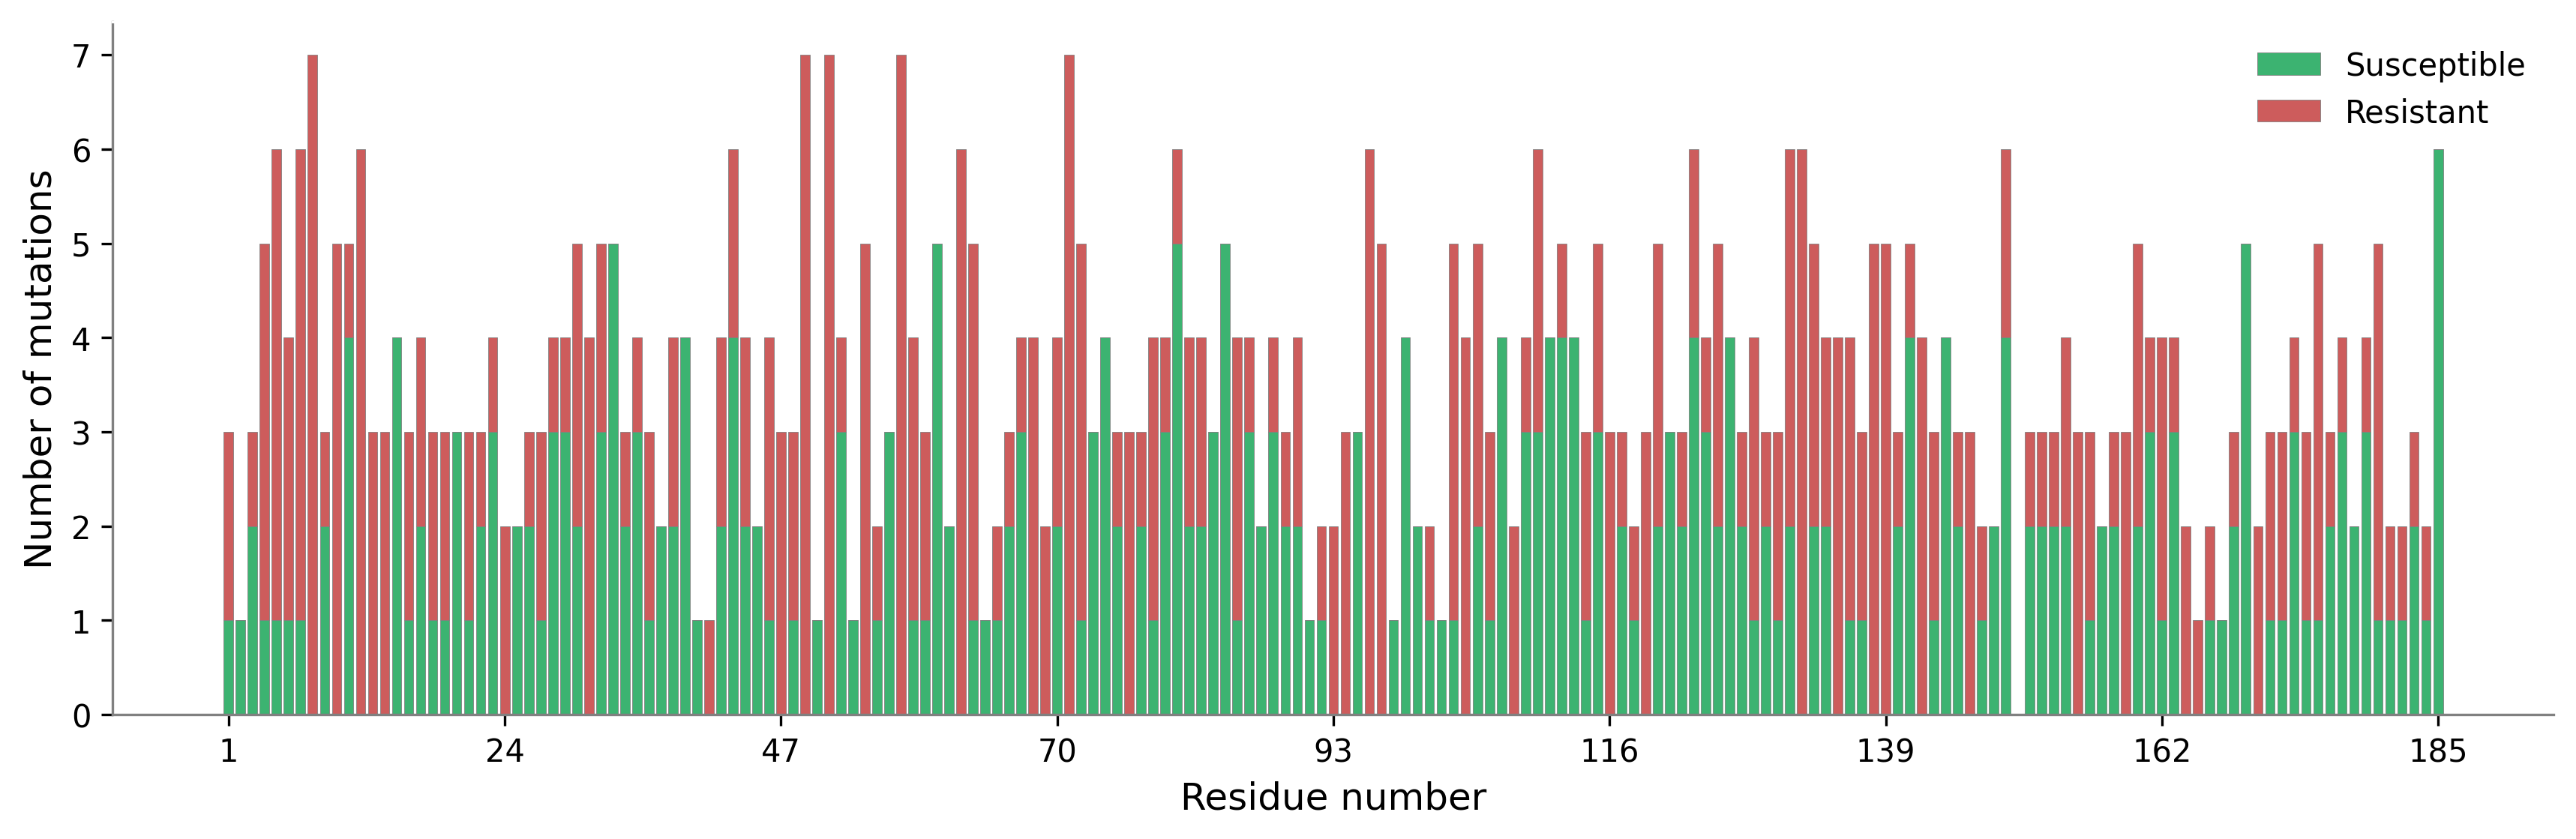

In [16]:
r_data = pnca_paper_dataset[pnca_paper_dataset.CONSISTENT_PHENOTYPE=='R']['AMINO_ACID'].value_counts()
s_data = pnca_paper_dataset[pnca_paper_dataset.CONSISTENT_PHENOTYPE=='S']['AMINO_ACID'].value_counts()

# Align the indices
all_indices = r_data.index.union(s_data.index)
r_data = r_data.reindex(all_indices, fill_value=0)
s_data = s_data.reindex(all_indices, fill_value=0)

plt.figure(figsize=(14, 4))

# Change figure outline color
plt.gca().spines['top'].set_color('white')
plt.gca().spines['right'].set_color('white')
plt.gca().spines['left'].set_color('gray')
plt.gca().spines['bottom'].set_color('gray')

green = 'mediumseagreen'
red = 'indianred'
edge_col = 'gray'

plt.bar(s_data.index, s_data.values, label='Susceptible', edgecolor= edge_col, color = green, linewidth=0.2)
plt.bar(r_data.index, r_data.values, bottom=s_data.values, label='Resistant', edgecolor= edge_col, color = red, linewidth=0.2)

plt.ylabel('Number of mutations', 
        #    fontsize = 12
           )
plt.xlabel('Residue number', 
        #    fontsize = 12
           )

plt.xticks(ticks=np.arange(1, len(all_indices) + 2, step=23), 
        #    fontsize= 12
           )
plt.yticks(
    # fontsize= 12
    )

# plt.title('Positions of resistant and susceptible mutations across PncA structure')
plt.legend(frameon=False)
plt.show()


### Model performance bar charts

Initially dummy data

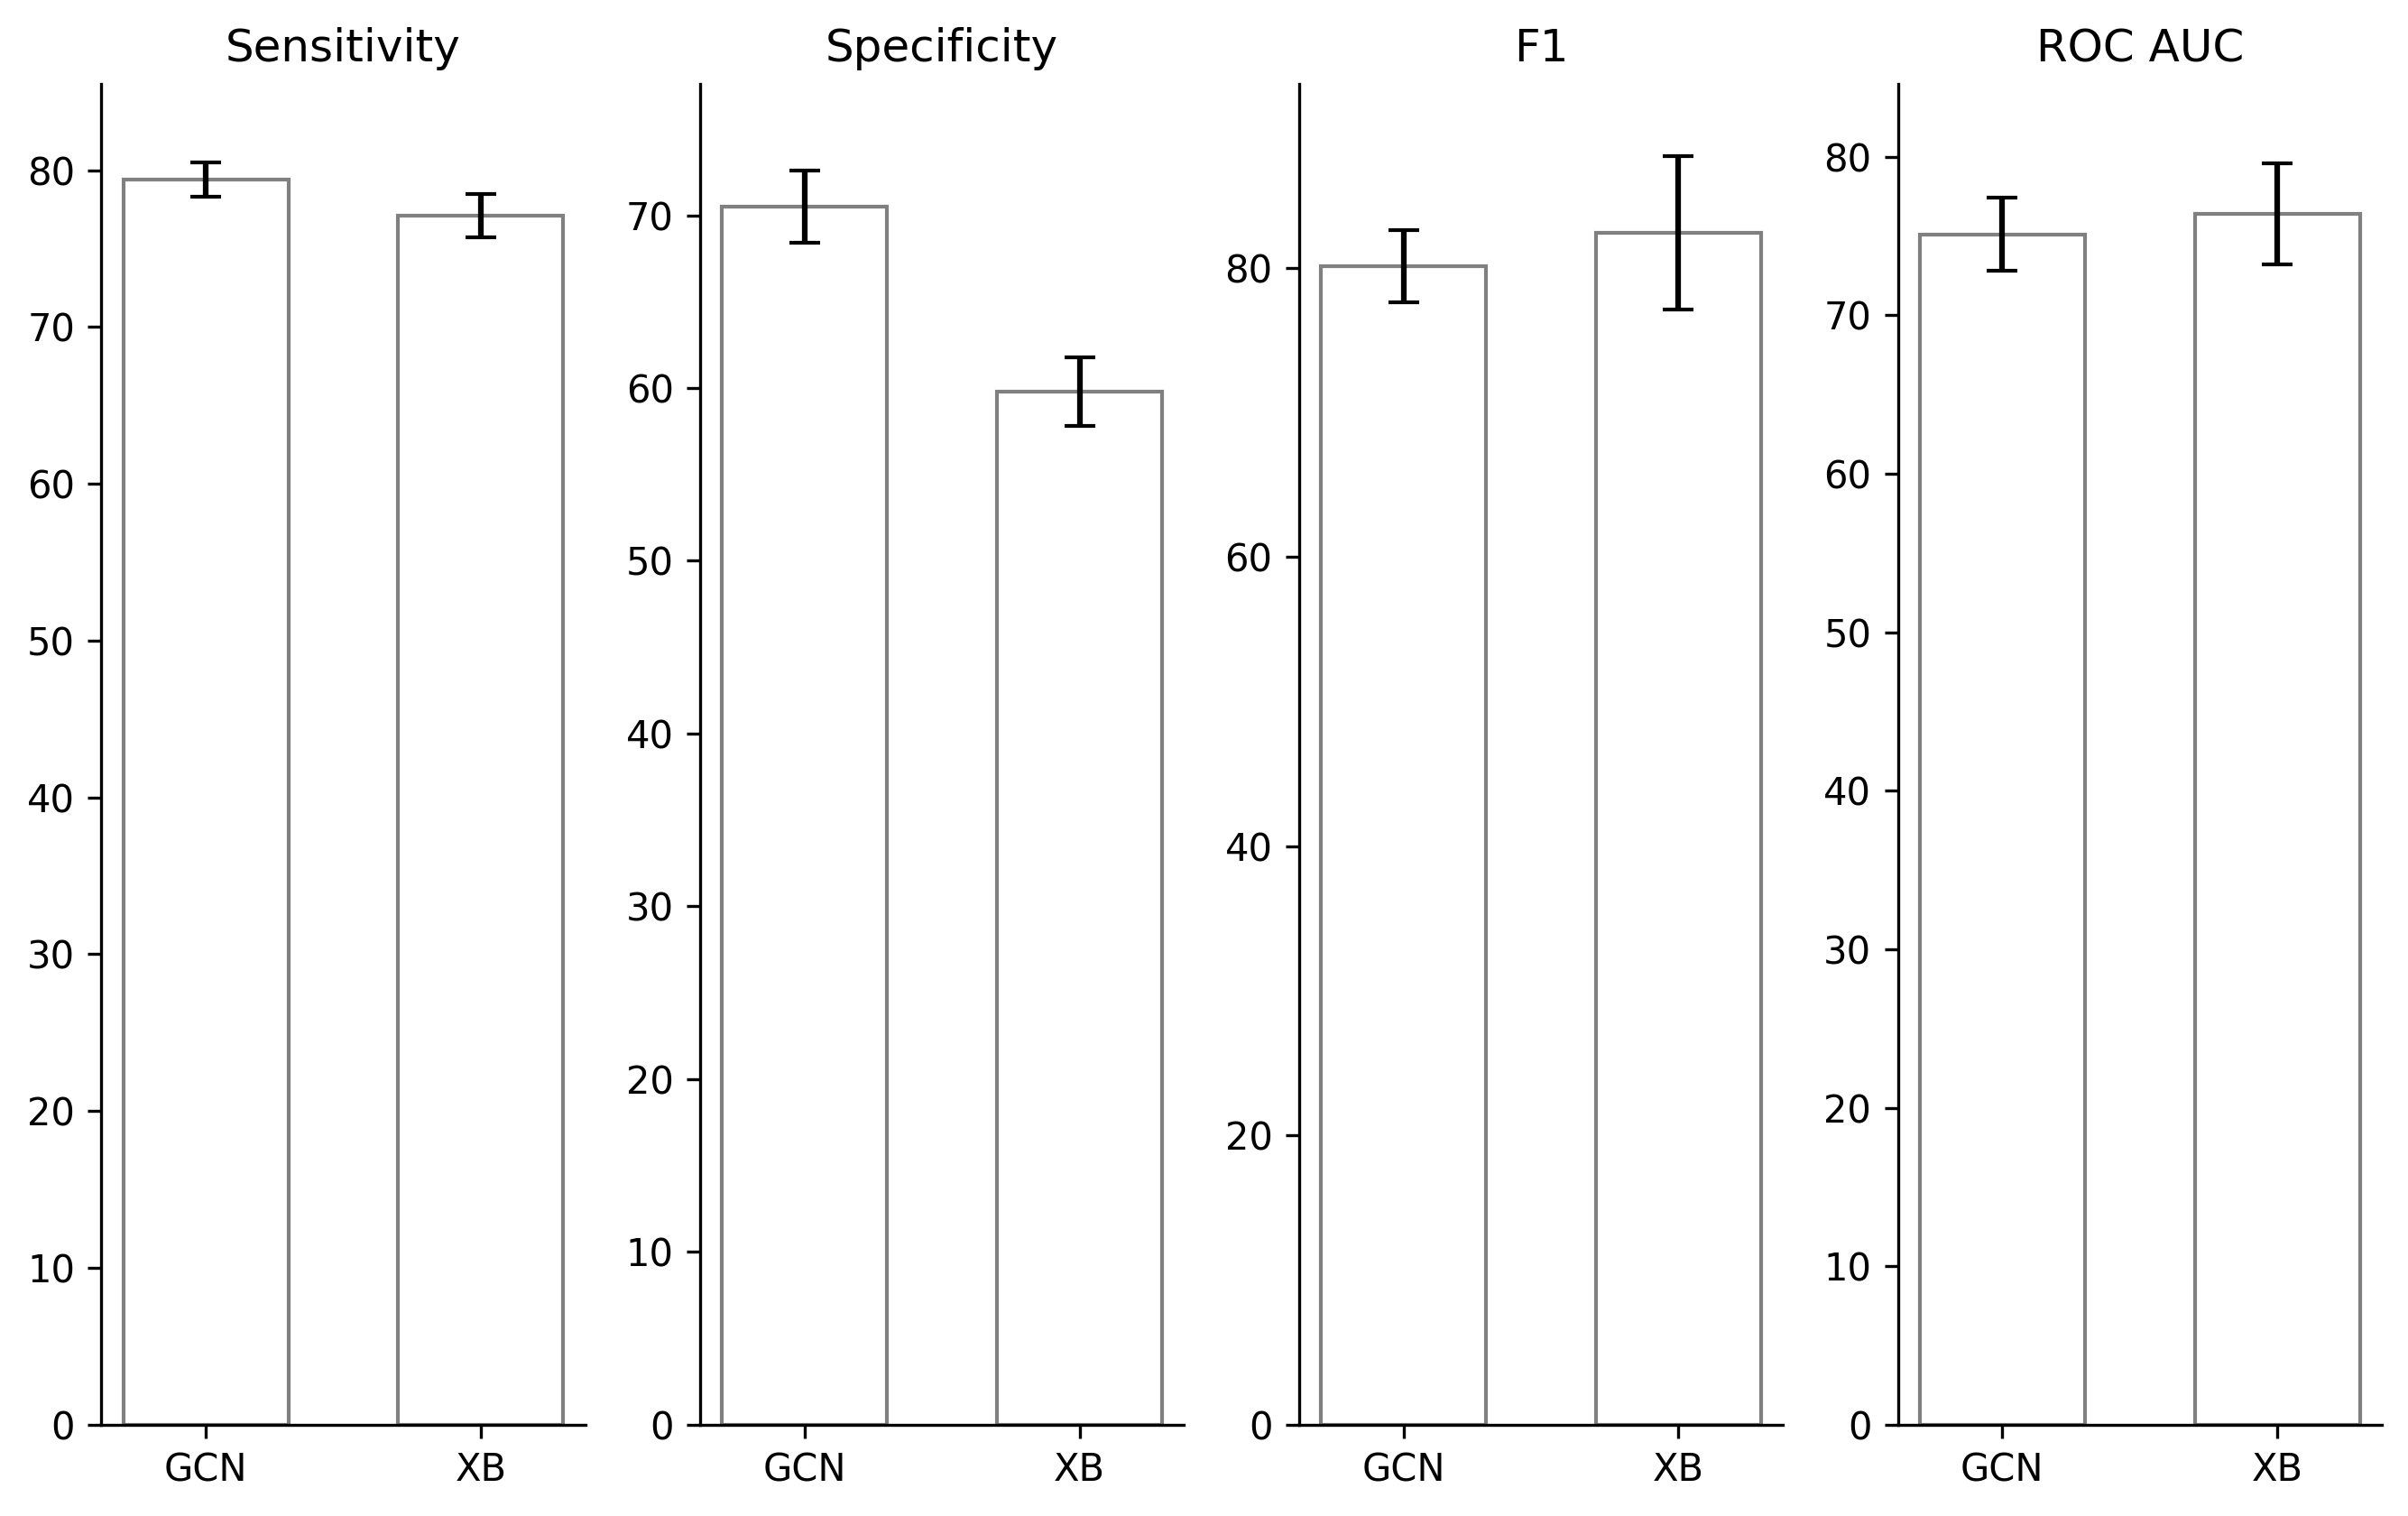

In [ ]:
models = ['GCN', 'XB']

metrics = {
    'Sensitivity': (np.array([79.4, 77.1]), np.array([1.1, 1.4])),
    'Specificity': (np.array([70.5, 59.8]), np.array([2.1, 2.0])),
    'F1':         (np.array([80.1, 82.4]),  np.array([2.5, 5.3])),
    'ROC AUC':    (np.array([75.1, 76.4]),  np.array([2.3, 3.2]))
}

def plot_metrics(ax, metric_data, title):
    bar_width = 0.6
    x = np.arange(len(models))
    
    for i, (metric, (vals, errs)) in enumerate(metric_data.items()):
        pos = x + i * (len(models) + 1)  # space between groups
        ax.bar(pos, vals, yerr=errs, capsize=4, width=bar_width, color='white', edgecolor='gray')
        ax.set_xticks(pos)
        ax.set_xticklabels(models)
        ax.set_title(title, loc='left', 
                    #  fontsize=10
                     )
        ax.set_ylabel(metric.lower(), 
                    #   fontsize=9
                      )
        ax.spines[['top', 'right']].set_visible(False)

# Create figure and subplots
fig, axs = plt.subplots(1, 4, figsize=(9, 6))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

# Plot each metric (test)
for i, (metric, data) in enumerate(metrics.items()):
    ax = axs[i]
    ax.bar(models, data[0], yerr=data[1], capsize=4, width=0.6, color='white', edgecolor='gray')
    ax.set_title(f'{metric}', 
                #  fontsize=10
                 )
    ax.set_ylim(0, max(data[0] + data[1]) + 5)
    ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

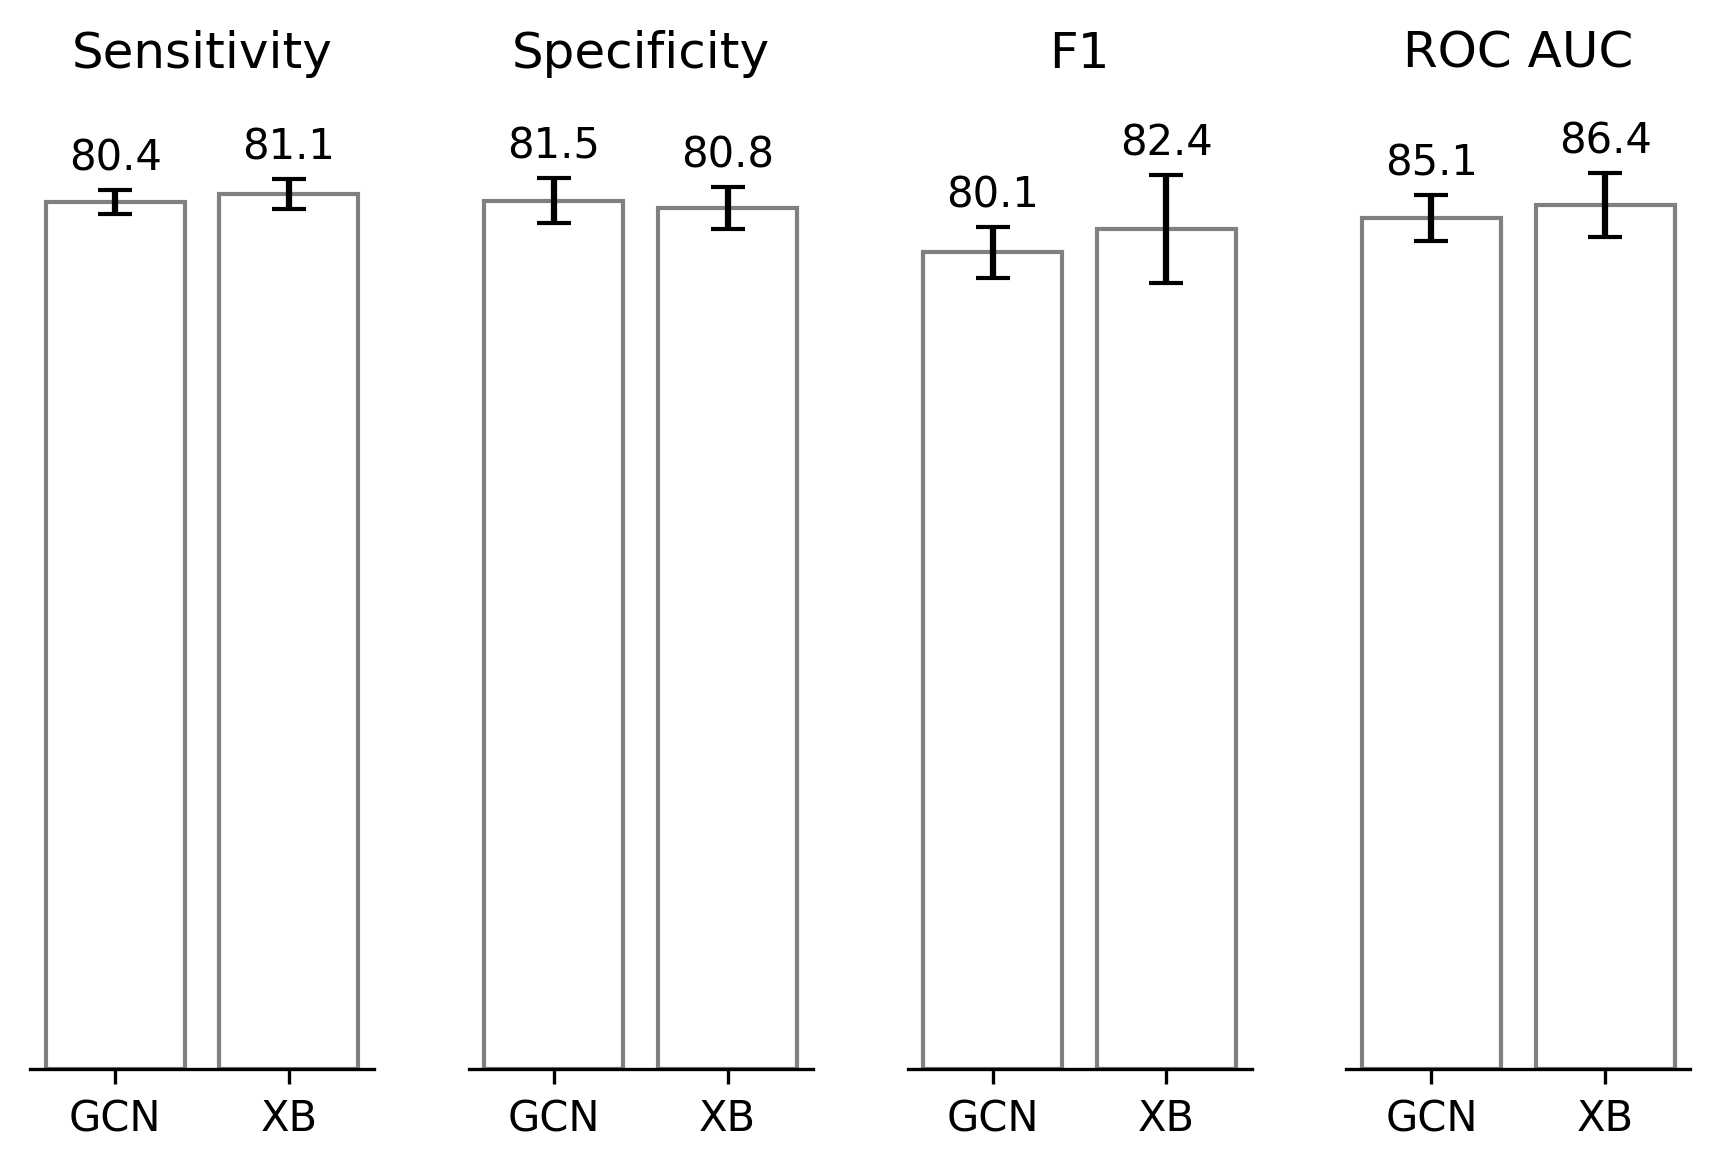

In [58]:
models = ['GCN', 'XB']

metrics = {
    'Sensitivity': (np.array([80.4, 81.1]), np.array([1.1, 1.4])),
    'Specificity': (np.array([81.5, 80.8]), np.array([2.1, 2.0])),
    'F1':         (np.array([80.1, 82.4]),  np.array([2.5, 5.3])),
    'ROC AUC':    (np.array([85.1, 86.4]),  np.array([2.3, 3.2]))
}

fig, axs = plt.subplots(1, 4, figsize=(6, 4))
fig.subplots_adjust(wspace=4)

for i, (metric, (vals, errs)) in enumerate(metrics.items()):
    ax = axs[i]
    bars = ax.bar(models, vals, yerr=errs, capsize=4, width=0.8, color='white', edgecolor='gray')
    
    # Add value labels above bars
    for bar, value, error in zip(bars, vals, errs):
        ax.text(bar.get_x() + bar.get_width() / 2, value + error + 1, f'{value:.1f}', 
                ha='center', va='bottom', 
                # fontsize=9
                )

    # Title only, no y-axis
    ax.set_title(metric)
    ax.set_xticks(np.arange(len(models)))
    ax.set_xticklabels(models)
    ax.set_ylim(0, max(vals + errs) + 8)
    ax.spines[['top', 'right', 'left']].set_visible(False)
    ax.tick_params(left=False, labelleft=False)

plt.tight_layout()
plt.show()